In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Merge customers and transactions data
customer_transactions = transactions.merge(customers, on='CustomerID', how='left')

# Feature Engineering

In [4]:
# 1. Total Spending per customer
total_spending = customer_transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spending.rename(columns={'TotalValue': 'TotalSpending'}, inplace=True)


In [5]:
# 2. Number of Transactions per customer
transaction_count = customer_transactions.groupby('CustomerID')['TransactionID'].nunique().reset_index()
transaction_count.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)


In [6]:
# 3. Average Transaction Value per customer
avg_transaction_value = customer_transactions.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

In [7]:
# 4. Customer Tenure (Days since signup)
customer_transactions['SignupDate'] = pd.to_datetime(customer_transactions['SignupDate'])
customer_transactions['CustomerTenure'] = (pd.to_datetime('today') - customer_transactions['SignupDate']).dt.days
customer_tenure = customer_transactions[['CustomerID', 'CustomerTenure']].drop_duplicates()

In [8]:
# 5. Region (One-hot encoding)
region_dummies = pd.get_dummies(customers['Region'], prefix='Region')


In [9]:
# Combine all features into a single dataframe
customer_features = customers[['CustomerID']].copy()
customer_features = customer_features.merge(total_spending, on='CustomerID', how='left')
customer_features = customer_features.merge(transaction_count, on='CustomerID', how='left')
customer_features = customer_features.merge(avg_transaction_value, on='CustomerID', how='left')
customer_features = customer_features.merge(customer_tenure, on='CustomerID', how='left')
customer_features = pd.merge(region_dummies, customer_features, left_index=True, right_index=True)

In [10]:
# Fill missing values with 0
customer_features = customer_features.fillna(0)


In [11]:
# Standardize the features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))


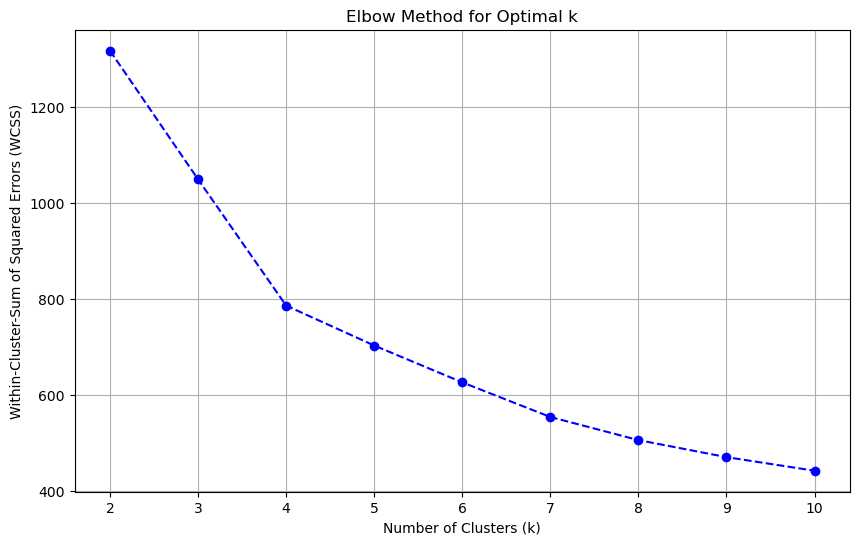

In [12]:
# Elbow Method to find optimal k
wcss = []  # Within-Cluster-Sum of Squared Errors
k_values = range(2, 11)  # Test k from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

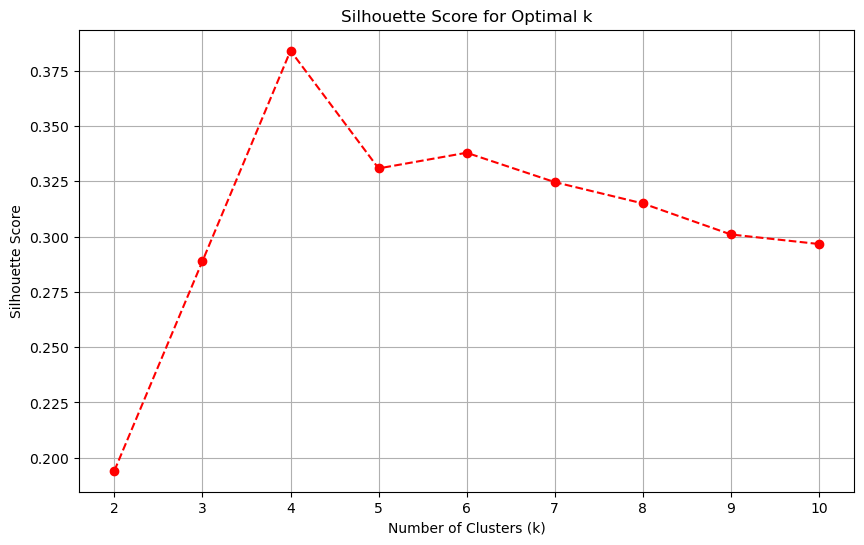

In [13]:
# Silhouette Score to find optimal k
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features_scaled)
    score = silhouette_score(customer_features_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='r')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [14]:
# Choose optimal k based on the Elbow Method and Silhouette Score
optimal_k = 4  # Change this based on the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)


In [15]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(customer_features_scaled, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.2f}")


Davies-Bouldin Index: 1.13


In [16]:
# Visualize clusters using PCA for 2D visualization
from sklearn.decomposition import PCA


In [17]:
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features_scaled)
customer_features['PCA1'] = customer_features_pca[:, 0]
customer_features['PCA2'] = customer_features_pca[:, 1]


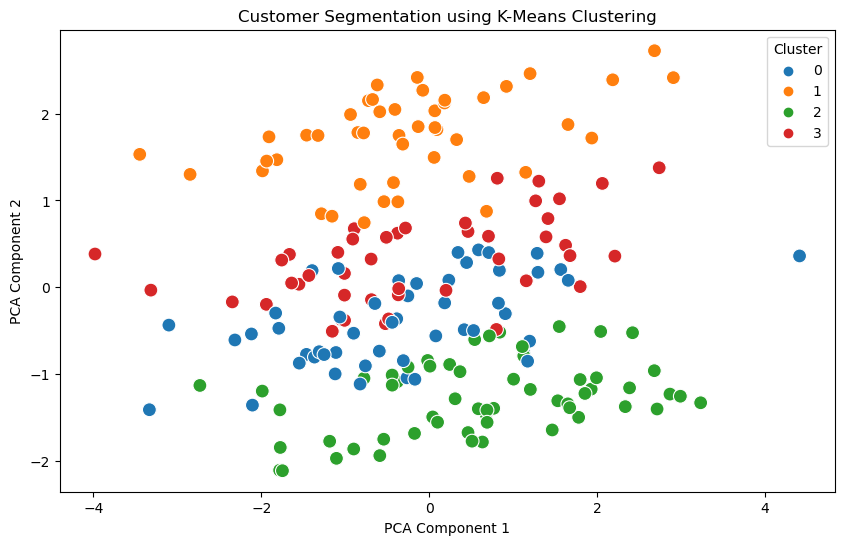

In [18]:
# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [19]:
# Clustering Report
print("\nClustering Report:")
print(f"Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_score(customer_features_scaled, kmeans.labels_):.2f}")


Clustering Report:
Number of Clusters: 4
Davies-Bouldin Index: 1.13
Silhouette Score: 0.38
